In [64]:
#pip install tiledb-vector-search

In [1]:
import tiledb

In [3]:
import os

api_token = os.environ.get('TILEDB_API_TOKEN')
if api_token is None:
    print("API_TOKEN not found in environment variables")

API_TOKEN not found in environment variables


In [6]:
tiledb.cloud.login(token=api_token)

In [7]:
import cellxgene_census.experimental

In [8]:
import cellxgene_census as cxg
import scanpy as sc
import numpy as np
import os
import pandas as pd
import glob
import re
import anndata as ad

In [ ]:
# compare UCE and counts using UMAP

In [8]:
adata = sc.read_h5ad("./UCE-postgithub/data/ggs_scp_chicken_retina_uce_adata.h5ad")

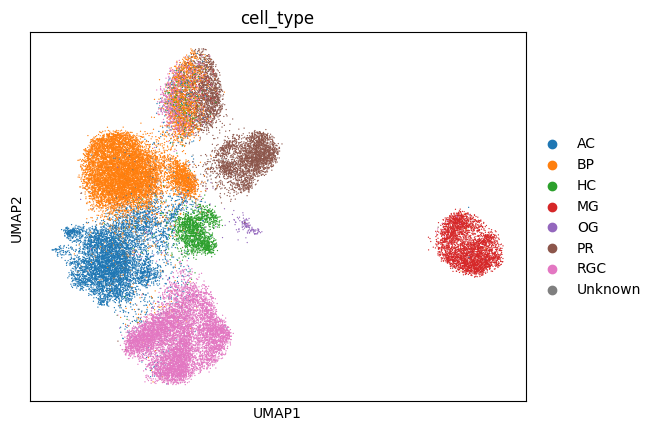

CPU times: user 34.1 s, sys: 18.6 s, total: 52.7 s
Wall time: 29.2 s


In [21]:
%%time
sc.pp.neighbors(adata, use_rep='X_uce')
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')

         Falling back to preprocessing with `sc.pp.pca` and default params.


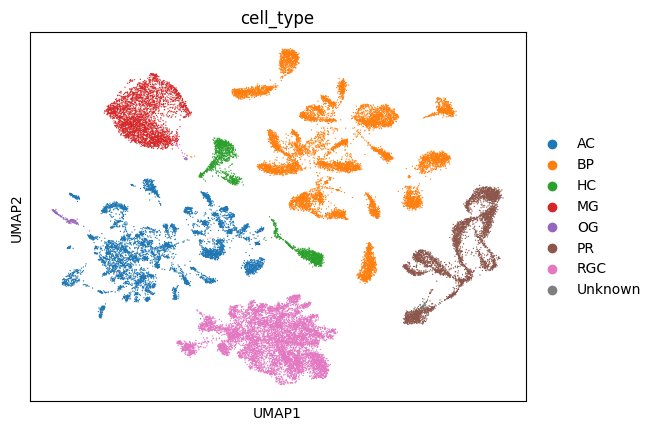

CPU times: user 6min 28s, sys: 9min 31s, total: 16min
Wall time: 38.9 s


In [18]:
%%time
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')

In [ ]:
#Check interspecies meaningfullness with cellxgene

In [9]:
g_adata = sc.read_h5ad("./UCE-postgithub/data/ggs_scp_chicken_retina_uce_adata.h5ad")

In [10]:
census = cxg.open_soma(census_version="2023-12-15")

In [47]:
pip install --upgrade tiledb

Note: you may need to restart the kernel to use updated packages.


In [18]:
%%time
h_adata = cxg.get_anndata(
    census,
    organism = "homo_sapiens",
    measurement_name = "RNA",
    obs_value_filter = "tissue_general == 'central nervous system'",
    obs_embeddings = ["uce"]
)

CPU times: user 30.7 s, sys: 37.1 s, total: 1min 7s
Wall time: 1min 8s


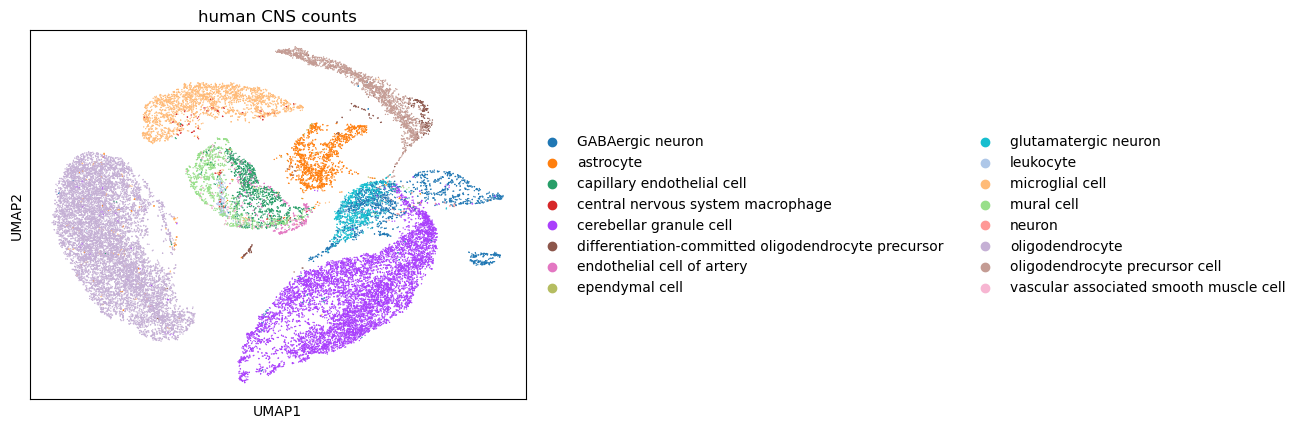

CPU times: user 31min 26s, sys: 182 ms, total: 31min 26s
Wall time: 1min 5s


In [12]:
%%time
sc.pp.neighbors(h_adata)
sc.tl.umap(h_adata)
sc.pl.umap(h_adata, color='cell_type', title='human CNS counts')

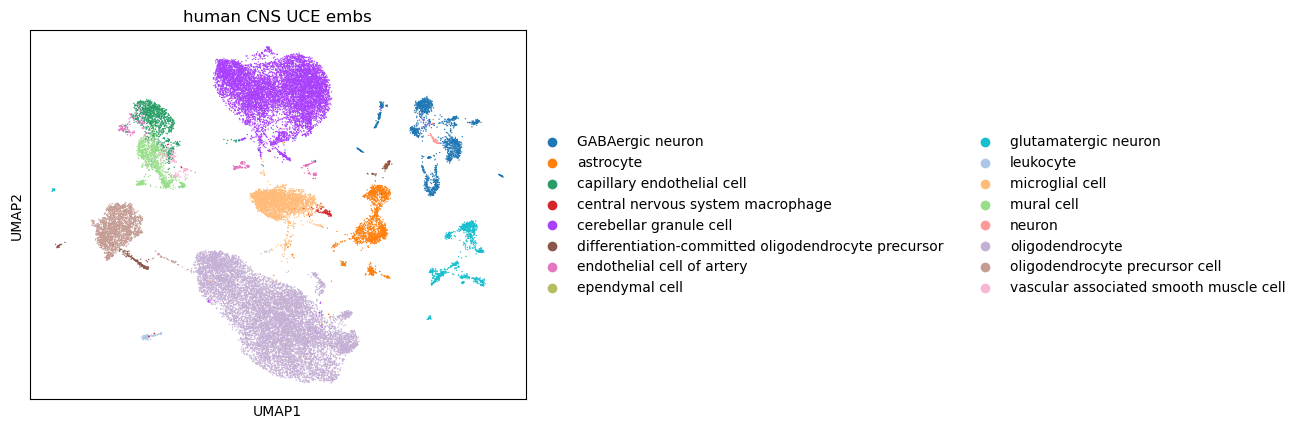

CPU times: user 51min 29s, sys: 448 ms, total: 51min 29s
Wall time: 1min 39s


In [15]:
%%time
sc.pp.neighbors(h_adata, use_rep='uce')
sc.tl.umap(h_adata)
sc.pl.umap(h_adata, color='cell_type', title='human CNS UCE embs')

In [25]:
fake_adata = ad.concat([h_adata, g_adata], join='inner')

In [34]:
uce_embs = np.vstack((h_adata.obsm['uce'], g_adata.obsm['X_uce']))

In [38]:
fake_adata.obsm['uce'] = uce_embs

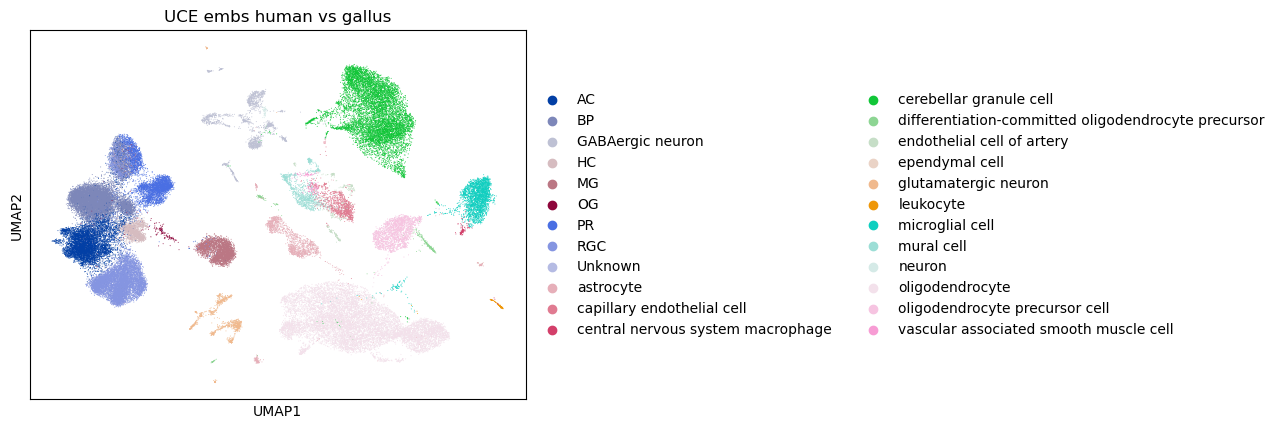

CPU times: user 1h 11min 46s, sys: 919 ms, total: 1h 11min 47s
Wall time: 2min 38s


In [42]:
%%time
sc.pp.neighbors(fake_adata, use_rep='uce')
sc.tl.umap(fake_adata)
sc.pl.umap(fake_adata, color='cell_type', title='UCE embs human vs gallus')

In [ ]:
# it seems like Gallus is still separated from Homo, but maybe corresponding celltypes of Gallus are still closest to corresponding celltypes in Homo?

In [11]:
g_adata.obsm['uce'] = g_adata.obsm['X_uce']

In [27]:
%%time
#find nearest neighbors for each uce embedded cell in first 5 cells in g_adata
neighbors = cellxgene_census.experimental.find_nearest_obs(
    "uce", "mus_musculus", "2023-12-15", query=g_adata[:5], k=5)

CPU times: user 2min 25s, sys: 3min 43s, total: 6min 9s
Wall time: 3min 8s


In [37]:
g_adata.obs['cell_type'][:5]

Chicken1A_AAACCTGAGTACGATA-1    PR
Chicken1A_AAACCTGCAACACCTA-1    BP
Chicken1A_AAACCTGCAGCTGTTA-1    BP
Chicken1A_AAACCTGGTCGAACAG-1    MG
Chicken1A_AAACCTGGTCGCATCG-1    BP
Name: cell_type, dtype: category
Categories (8, object): ['AC', 'BP', 'HC', 'MG', 'OG', 'PR', 'RGC', 'Unknown']

In [38]:
for n in neighbors[1]:
    for m in n:
        print(cxg.get_obs(census=census, organism='mus_musculus', value_filter=f"soma_joinid=={m}")["cell_type"][0])
    print("::::::::::::::::::::::::::::")

neuron
neuron
keratinocyte stem cell
thymocyte
thymocyte
::::::::::::::::::::::::::::
neuron
thymocyte
neuron
neuron
thymocyte
::::::::::::::::::::::::::::
professional antigen presenting cell
professional antigen presenting cell
thymocyte
thymocyte
thymocyte
::::::::::::::::::::::::::::
neuron
myeloid cell
neuron
skeletal muscle satellite cell
skeletal muscle satellite cell
::::::::::::::::::::::::::::
endothelial cell of coronary artery
myeloid cell
neuron
thymocyte
neuron
::::::::::::::::::::::::::::


In [ ]:
#it doesn't work too well, but at least almost all of the celltypes (as described in https://elifesciences.org/articles/63907) map to ~neurons. 
#When the same thing was done for human census instead of mouse, results were way worse.
#It might be interesting to investigate this further in the future.
